(empirical-approx-overview)=

# Empirical Approximation overview

For most models we use sampling MCMC algorithms like Metropolis or NUTS. In PyMC we got used to store traces of MCMC samples and then do analysis using them. There is a similar concept for the variational inference submodule in PyMC: *Empirical*. This type of approximation stores particles for the SVGD sampler. There is no difference between independent SVGD particles and MCMC samples. *Empirical* acts as a bridge between MCMC sampling output and full-fledged VI utils like `apply_replacements` or `sample_node`. For the interface description, see [variational_api_quickstart](variational_api_quickstart.ipynb). Here we will just focus on `Emprical` and give an overview of specific things for the *Empirical* approximation.

:::{post} Jan 13, 2023 
:tags: variational inference, approximation
:category: advanced, how-to
:author: Maxim Kochurov, Raul Maldonado, Chris Fonnesbeck
:::

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor
import seaborn as sns

from pandas import DataFrame

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.0.1


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
np.random.seed(42)

## Multimodal density
Let's recall the problem from [variational_api_quickstart](variational_api_quickstart.ipynb) where we first got a NUTS trace

In [3]:
w = pm.floatX([0.2, 0.8])
mu = pm.floatX([-0.3, 0.5])
sd = pm.floatX([0.1, 0.1])

with pm.Model() as model:
    x = pm.NormalMixture("x", w=w, mu=mu, sigma=sd)
    trace = pm.sample(50_000, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]


Sampling 4 chains for 1_000 tune and 50_000 draw iterations (4_000 + 200_000 draws total) took 87 seconds.


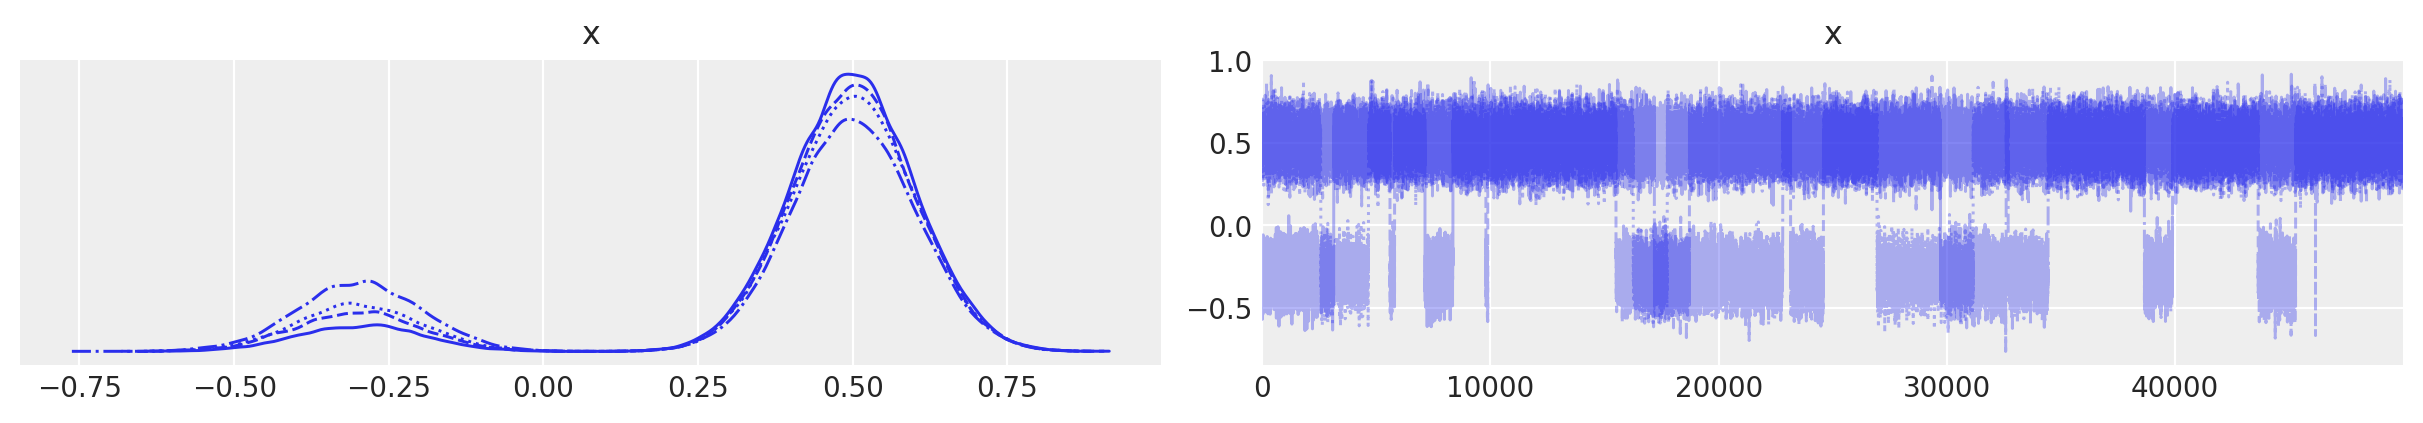

In [4]:
with model:
    idata = pm.to_inference_data(trace)
az.plot_trace(idata);

Great. First having a trace we can create `Empirical` approx

In [5]:
print(pm.Empirical.__doc__)

**Single Group Full Rank Approximation**

    Builds Approximation instance from a given trace,
    it has the same interface as variational approximation
    


In [6]:
with model:
    approx = pm.Empirical(trace)

In [7]:
approx

This type of approximation has it's own underlying storage for samples that is `pytensor.shared` itself

In [8]:
approx.histogram

histogram

In [9]:
approx.histogram.get_value()[:10]

array([[-0.27366748],
       [-0.32806332],
       [-0.56953621],
       [-0.2994719 ],
       [-0.18962334],
       [-0.24262214],
       [-0.36759098],
       [-0.23522732],
       [-0.37741766],
       [-0.3298074 ]])

In [10]:
approx.histogram.get_value().shape

(200000, 1)

It has exactly the same number of samples that you had in trace before. In our particular case it is 50k.  Another thing to notice is that if you have multitrace with **more than one chain** you'll get much **more samples** stored at once. We flatten all the trace for creating `Empirical`.

This *histogram* is about *how* we store samples. The structure is pretty simple: `(n_samples, n_dim)` The order of these variables is stored internally in the class and in most cases will not be needed for end user

In [11]:
approx.ordering

OrderedDict([('x', ('x', slice(0, 1, None), (), dtype('float64')))])

Sampling from posterior is done uniformly with replacements. Call `approx.sample(1000)` and you'll get again the trace but the order is not determined. There is no way now to reconstruct the underlying trace again with `approx.sample`.

In [12]:
new_trace = approx.sample(50000)

After sampling function is compiled sampling bacomes really fast

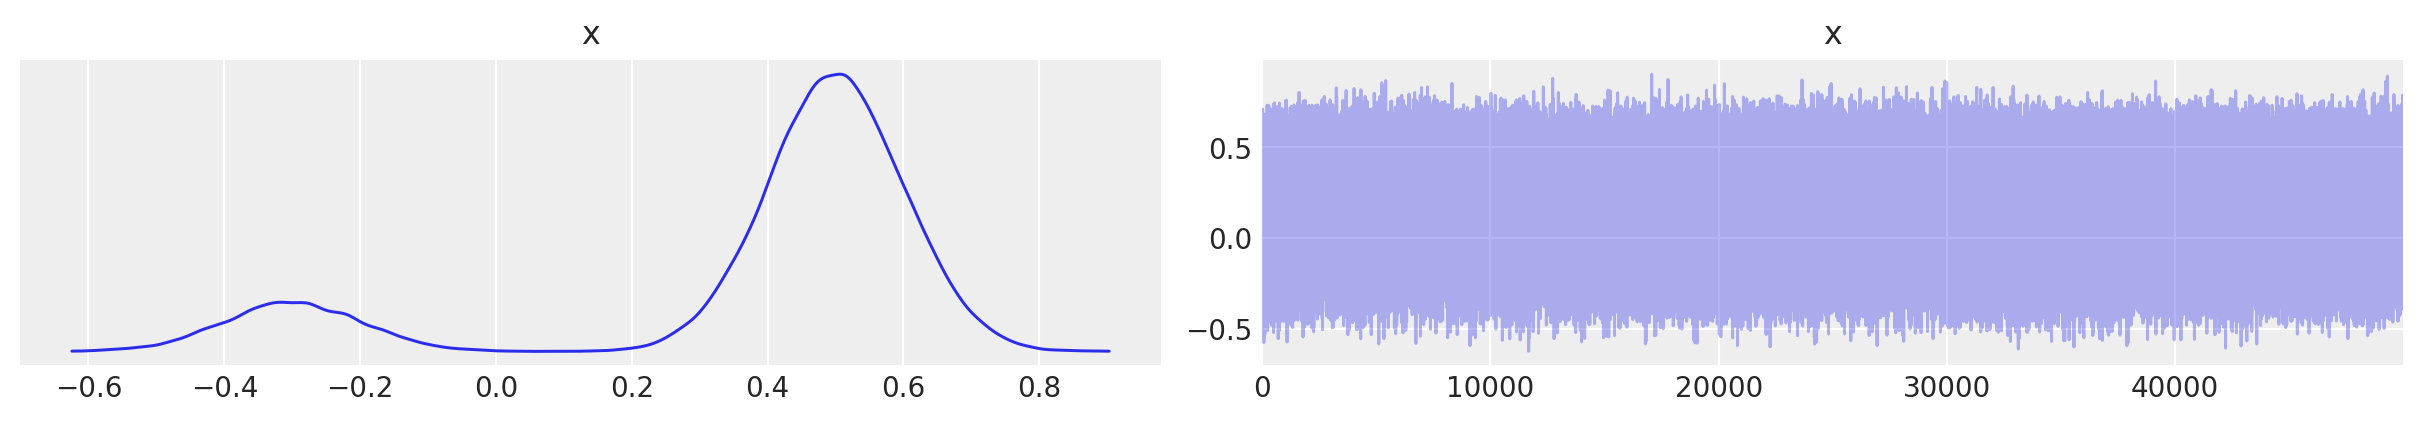

In [13]:
az.plot_trace(new_trace);

You see there is no order any more but reconstructed density is the same.

## 2d density

In [14]:
mu = pm.floatX([0.0, 0.0])
cov = pm.floatX([[1, 0.5], [0.5, 1.0]])
with pm.Model() as model:
    pm.MvNormal("x", mu=mu, cov=cov, shape=2)
    trace = pm.sample(1000, return_inferencedata=False)
    idata = pm.to_inference_data(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


In [15]:
with model:
    approx = pm.Empirical(trace)

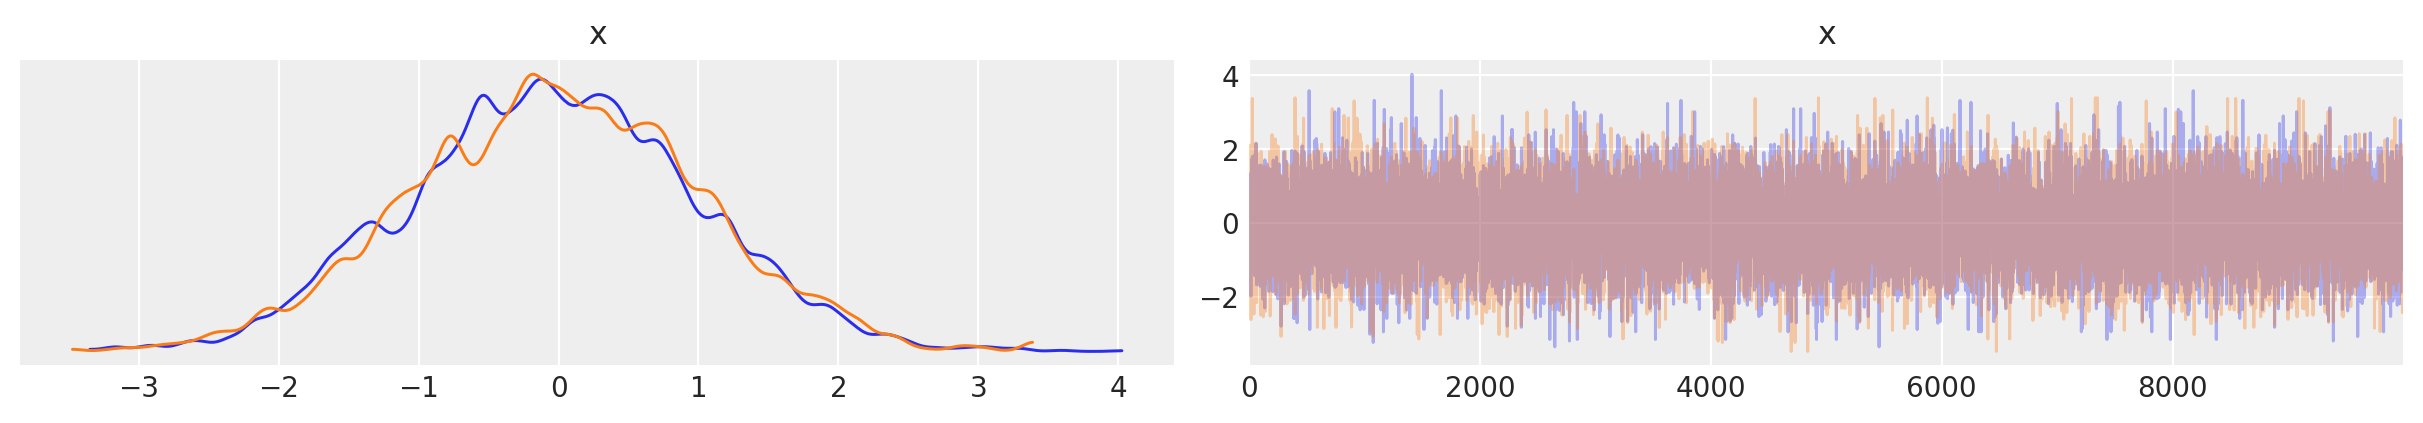

In [16]:
az.plot_trace(approx.sample(10000));

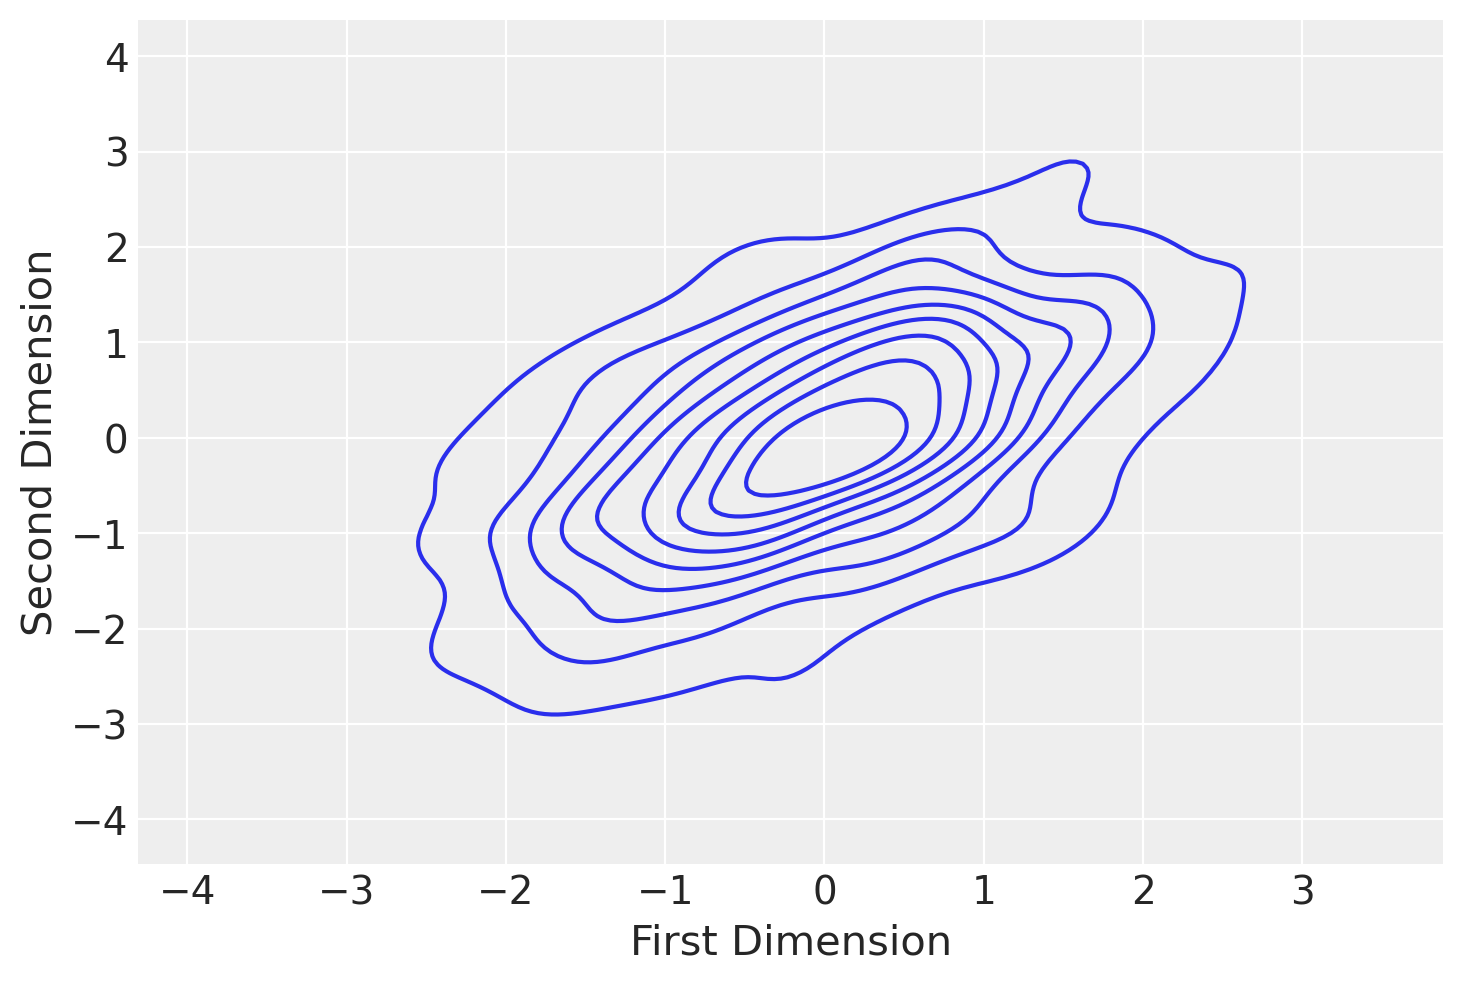

In [17]:
kdeViz_df = DataFrame(
    data=approx.sample(1000).posterior["x"].squeeze(),
    columns=["First Dimension", "Second Dimension"],
)

sns.kdeplot(data=kdeViz_df, x="First Dimension", y="Second Dimension")
plt.show()

Previously we had a `trace_cov` function

In [18]:
with model:
    print(pm.trace_cov(trace))

[[1.04134257 0.53158646]
 [0.53158646 1.02179671]]


Now we can estimate the same covariance using `Empirical`

In [19]:
print(approx.cov)

Elemwise{true_div,no_inplace}.0


That's a tensor object, which we need to evaluate.

In [20]:
print(approx.cov.eval())

[[1.04108223 0.53145356]
 [0.53145356 1.02154126]]


Estimations are very close and differ due to precision error. We can get the mean in the same way

In [21]:
print(approx.mean.eval())

[-0.03548692 -0.03420244]


## Authors

* Authored by Maxim Kochurov ([pymc#2389](https://github.com/pymc-devs/pymc/pull/2389]))
* Updated by Maxim Kochurov ([pymc#2416](https://github.com/pymc-devs/pymc/pull/2416))
* Updated by Raul Maldonado ([pymc-examples#21](https://github.com/pymc-devs/pymc-examples/pull/21))
* Updated by Chris Fonnesbeck  ([pymc-examples#429](https://github.com/pymc-devs/pymc-examples/pull/497))

## Watermark

In [22]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Fri Jan 13 2023

Python implementation: CPython
Python version       : 3.9.0
IPython version      : 8.8.0

pymc      : 5.0.1
pytensor  : 2.8.11
arviz     : 0.14.0
sys       : 3.9.0 | packaged by conda-forge | (default, Nov 26 2020, 07:57:39) 
[GCC 9.3.0]
numpy     : 1.23.5
seaborn   : 0.12.2
matplotlib: 3.6.2

Watermark: 2.3.1



:::{include} ../page_footer.md
:::